In [2]:
%load_ext autoreload
%autoreload 2
import numpy as np
import os
import time
import matplotlib.pyplot as plt
import cv2
import torch
plt.rc('figure', figsize=(20, 15))

In [2]:
class SuperPointNet(torch.nn.Module):
    """ Pytorch definition of SuperPoint Network. """
    def __init__(self, ):
        super(SuperPointNet, self).__init__()
        self.relu = torch.nn.ReLU(inplace=True)
        self.pool = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        c1, c2, c3, c4, c5, d1 = 64, 64, 128, 128, 256, 256
        # Shared Encoder.
        self.conv1a = torch.nn.Conv2d(1, c1, kernel_size=3, stride=1, padding=1)
        self.conv1b = torch.nn.Conv2d(c1, c1, kernel_size=3, stride=1, padding=1)
        self.conv2a = torch.nn.Conv2d(c1, c2, kernel_size=3, stride=1, padding=1)
        self.conv2b = torch.nn.Conv2d(c2, c2, kernel_size=3, stride=1, padding=1)
        self.conv3a = torch.nn.Conv2d(c2, c3, kernel_size=3, stride=1, padding=1)
        self.conv3b = torch.nn.Conv2d(c3, c3, kernel_size=3, stride=1, padding=1)
        self.conv4a = torch.nn.Conv2d(c3, c4, kernel_size=3, stride=1, padding=1)
        self.conv4b = torch.nn.Conv2d(c4, c4, kernel_size=3, stride=1, padding=1)
        # Detector Head.
        self.convPa = torch.nn.Conv2d(c4, c5, kernel_size=3, stride=1, padding=1)
        self.convPb = torch.nn.Conv2d(c5, 65, kernel_size=1, stride=1, padding=0)
        # Descriptor Head.
        self.convDa = torch.nn.Conv2d(c4, c5, kernel_size=3, stride=1, padding=1)
        self.convDb = torch.nn.Conv2d(c5, d1, kernel_size=1, stride=1, padding=0)

    def forward(self, x, debug=False):
        """ Forward pass that jointly computes unprocessed point and descriptor
        tensors.
        Input
          x: Image pytorch tensor shaped N x 1 x H x W.
        Output
          semi: Output point pytorch tensor shaped N x 65 x H/8 x W/8.
          desc: Output descriptor pytorch tensor shaped N x 256 x H/8 x W/8.
        """
        # Shared Encoder.
        H = x.size(2)
        W = x.size(3)
        x = self.relu(self.conv1a(x))
        x = self.relu(self.conv1b(x))
        x = self.pool(x)
        x = self.relu(self.conv2a(x))
        x = self.relu(self.conv2b(x))
        x = self.pool(x)
        x = self.relu(self.conv3a(x))
        x = self.relu(self.conv3b(x))
        x = self.pool(x)
        x = self.relu(self.conv4a(x))
        x = self.relu(self.conv4b(x))
        # Detector Head.
        cPa = self.relu(self.convPa(x))
        semi = self.convPb(cPa)
        # Descriptor Head.
        cDa = self.relu(self.convDa(x))
        desc = self.convDb(cDa)
        dn = torch.norm(desc, p=2, dim=1) # Compute the norm.
        desc = desc.div(torch.unsqueeze(dn, 1)) # Divide by norm to normalize.
        
        semi = torch.softmax(semi, 1)
        semi = semi.narrow(1, 0, 64)
        semi = semi.permute((0, 2, 3, 1))

        Hc = semi.size(1)
        Wc = semi.size(2)
        semi = semi.contiguous().view((-1, Hc, Wc, 8, 8))
        semi = semi.permute((0, 1, 3, 2, 4))
        semi = semi.contiguous().view((-1, Hc * 8, Wc * 8)) 
        
        #Only works for single batch now
        kps = torch.nonzero(semi > 0.2)[:,1:3]
        grid = kps[:,[1,0]].type(torch.FloatTensor)
        grid[:,0] = grid[:,0]/W
        grid[:,1] = grid[:,1]/H
        grid = grid.unsqueeze(0)
        grid = grid.unsqueeze(0)*2.0 - 1.0
        desc = torch.nn.functional.grid_sample(desc, grid)
        desc = desc.squeeze(0).squeeze(1)
        
        dn = torch.norm(desc, 2, 1)
        desc = desc.div(torch.unsqueeze(dn, 1))

        desc = desc.transpose(0, 1).contiguous()
        if debug:
            return semi, kps, desc

        return kps, desc

In [3]:
from sklearn.decomposition import PCA
import numpy as np
#16 is min num for left right match
pca = PCA(64)
data = np.loadtxt("/home/xuhao/output/superpoint-desc.csv")
_data = pca.fit_transform(data)

/home/xuhao/anaconda3/lib/python3.8/site-packages/torch/nn/functional.py:3385: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "


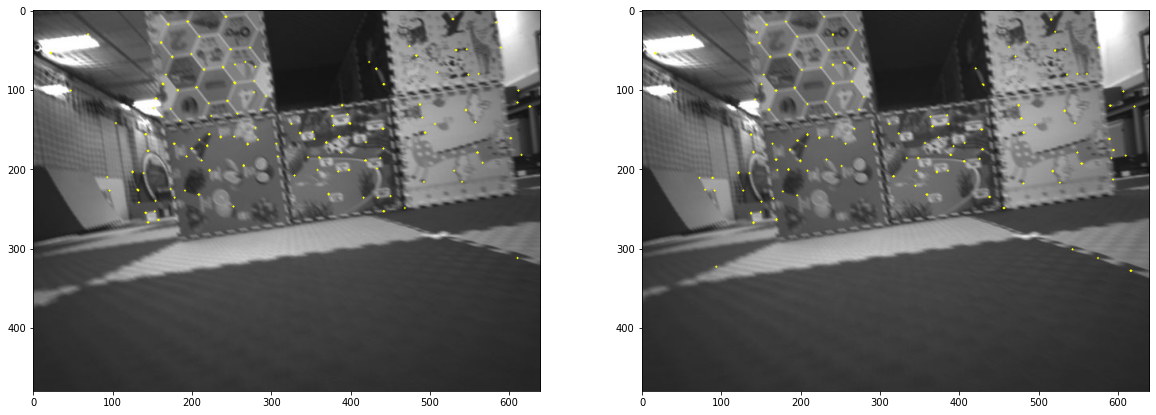

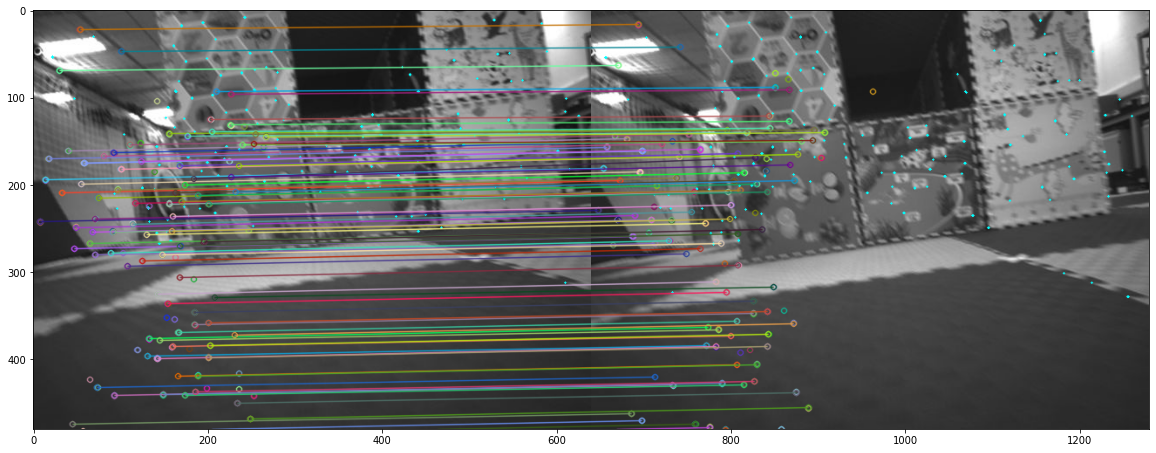

(189, 64) (185, 64) float32
(189, 64) (185, 64)


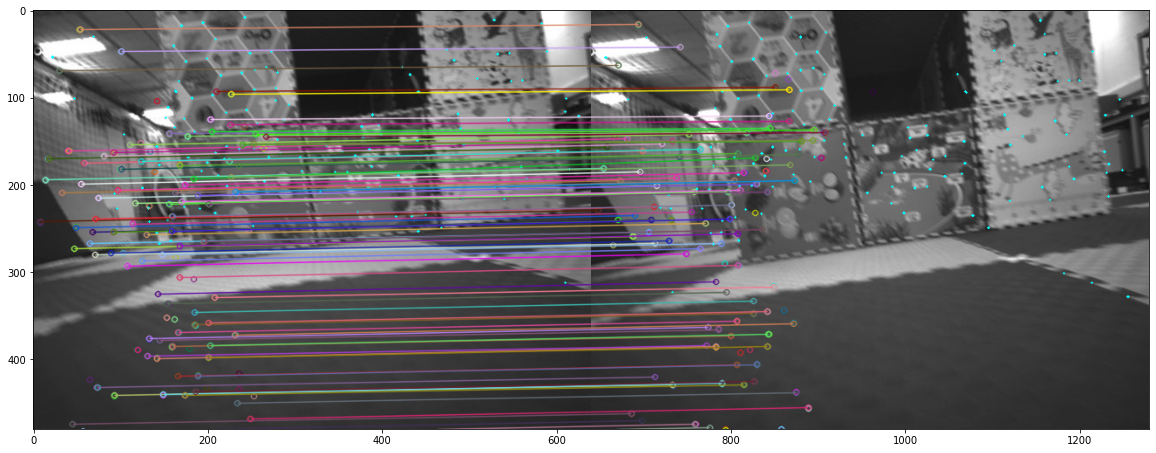

In [4]:
model = SuperPointNet()
model.load_state_dict(torch.load("models/superpoint_v1.pth"))
model.eval()
_img = cv2.imread("/home/xuhao/output/left.jpg")
_img_r = cv2.imread("/home/xuhao/output/right.jpg")
def inference(_img):
    _img = cv2.cvtColor(_img, cv2.COLOR_BGR2GRAY)
    img = np.expand_dims(_img, axis=0)
    img = np.expand_dims(img, axis=0)
    img = img.astype(np.float32)/255
    x = torch.tensor(img)
    kps, desc = model.forward(x, False)
    return  kps.detach().numpy(), desc.detach().numpy()

def toCvKps(kps):
    ret = []
    for kp in kps:
        _kp = cv2.KeyPoint(float(kp[0]), float(kp[1]), 1)
#         _kp.pt = kp
        ret.append(_kp)
    return ret
        
kps0, desc0 = inference(_img)
kps1, desc1 = inference(_img_r)
for i in range(len(kps0)):
    cv2.circle(_img, (kps0[i][1], kps0[i][0]), 1, (0, 255, 255), -1)
for i in range(len(kps1)):
    cv2.circle(_img_r, (kps1[i][1], kps1[i][0]), 1, (0, 255, 255), -1)

plt.subplot(121)
plt.imshow(cv2.cvtColor(_img, cv2.COLOR_BGR2RGB))   
plt.subplot(122)
plt.imshow(cv2.cvtColor(_img_r, cv2.COLOR_BGR2RGB))
plt.show()

bf = cv2.BFMatcher(cv2.NORM_L2, True)
matches = bf.match(desc0, desc1)

img3 = cv2.drawMatches(_img,toCvKps(kps0),_img_r,toCvKps(kps1),matches, None)
plt.imshow(img3)
plt.show()

desc0 = pca.transform(desc0).astype(np.float32)
desc1 = pca.transform(desc1).astype(np.float32)

print(desc0.shape, desc1.shape, desc0.dtype)
print(desc0.shape, desc1.shape)
bf2 = cv2.BFMatcher(cv2.NORM_L2, True)
matches = bf2.match(desc0, desc1)

img3 = cv2.drawMatches(_img,toCvKps(kps0),_img_r,toCvKps(kps1),matches, None)
plt.imshow(img3)
plt.show()

In [5]:
#Use superglue to perform matching
import sys
sys.path.append('/home/xuhao/source/SuperGluePretrainedNetwork')
from models.superglue import SuperGlue
device = 'cuda' if torch.cuda.is_available() else 'cpu'
cfg = {'weights': 'indoor', #Or outdoor
       'sinkhorn_iterations': 20,
        'match_threshold': 0.2 }
superglue = SuperGlue(cfg)
data = {
  "keypoints0":kps0,
  "descriptors0":desc0,
  "keypoints1":kps1,
  "descriptors1":desc1,
}
superglue(data)

Loaded SuperGlue model ("indoor" weights)


KeyError: 'scores0'

In [3]:
#Output to onnx.
class SuperPointNetHalf(torch.nn.Module):
    """ Pytorch definition of SuperPoint Network. """
    def __init__(self, ):
        super(SuperPointNetHalf, self).__init__()
        self.relu = torch.nn.ReLU(inplace=True)
        self.pool = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        c1, c2, c3, c4, c5, d1 = 64, 64, 128, 128, 256, 256
        # Shared Encoder.
        self.conv1a = torch.nn.Conv2d(1, c1, kernel_size=3, stride=1, padding=1)
        self.conv1b = torch.nn.Conv2d(c1, c1, kernel_size=3, stride=1, padding=1)
        self.conv2a = torch.nn.Conv2d(c1, c2, kernel_size=3, stride=1, padding=1)
        self.conv2b = torch.nn.Conv2d(c2, c2, kernel_size=3, stride=1, padding=1)
        self.conv3a = torch.nn.Conv2d(c2, c3, kernel_size=3, stride=1, padding=1)
        self.conv3b = torch.nn.Conv2d(c3, c3, kernel_size=3, stride=1, padding=1)
        self.conv4a = torch.nn.Conv2d(c3, c4, kernel_size=3, stride=1, padding=1)
        self.conv4b = torch.nn.Conv2d(c4, c4, kernel_size=3, stride=1, padding=1)
        # Detector Head.
        self.convPa = torch.nn.Conv2d(c4, c5, kernel_size=3, stride=1, padding=1)
        self.convPb = torch.nn.Conv2d(c5, 65, kernel_size=1, stride=1, padding=0)
        # Descriptor Head.
        self.convDa = torch.nn.Conv2d(c4, c5, kernel_size=3, stride=1, padding=1)
        self.convDb = torch.nn.Conv2d(c5, d1, kernel_size=1, stride=1, padding=0)

    def forward(self, x, debug=False):
        """ Forward pass that jointly computes unprocessed point and descriptor
        tensors.
        Input
          x: Image pytorch tensor shaped N x 1 x H x W.
        Output
          semi: Output point pytorch tensor shaped N x 65 x H/8 x W/8.
          desc: Output descriptor pytorch tensor shaped N x 256 x H/8 x W/8.
        """
        # Shared Encoder.
        H = x.size(2)
        W = x.size(3)
        x = self.relu(self.conv1a(x))
        x = self.relu(self.conv1b(x))
        x = self.pool(x)
        x = self.relu(self.conv2a(x))
        x = self.relu(self.conv2b(x))
        x = self.pool(x)
        x = self.relu(self.conv3a(x))
        x = self.relu(self.conv3b(x))
        x = self.pool(x)
        x = self.relu(self.conv4a(x))
        x = self.relu(self.conv4b(x))
        # Detector Head.
        cPa = self.relu(self.convPa(x))
        semi = self.convPb(cPa)
        # Descriptor Head.
        cDa = self.relu(self.convDa(x))
        desc = self.convDb(cDa)
        dn = torch.norm(desc, p=2, dim=1) # Compute the norm.
        desc = desc.div(torch.unsqueeze(dn, 1)) # Divide by norm to normalize.
        
        semi = torch.softmax(semi, 1)
        semi = semi.narrow(1, 0, 64)
        semi = semi.permute((0, 2, 3, 1))

        Hc = semi.size(1)
        Wc = semi.size(2)
        semi = semi.contiguous().view((-1, Hc, Wc, 8, 8))
        semi = semi.permute((0, 1, 3, 2, 4))
        semi = semi.contiguous().view((-1, Hc * 8, Wc * 8)) 
        
        #Only works for single batch now
        if debug:
            kps = torch.nonzero(semi > 0.015)[:,1:3]
            return semi, kps, desc

        return semi, desc
    
# Input to the model
#_img = cv2.imread("sample.jpg")[0:208, 0: 400]
_img = cv2.imread("/home/xuhao/output/left.jpg")
_img = cv2.resize(_img, (640, 480))
_img = cv2.cvtColor(_img, cv2.COLOR_BGR2GRAY)
img = np.expand_dims(_img, axis=0)
img = np.expand_dims(img, axis=0)
img = img.astype(np.float32)/255.0
x = torch.tensor(img)
model = SuperPointNetHalf()
model.load_state_dict(torch.load("models/superpoint_v1.pth"))
dynamic_axes = {
    'image': {2: "height", 3: "width"},
    'semi': {1: "height", 2: "width"},
    'desc': {2: "desc_height", 3: "desc_width"},
}
# Export the model
torch.onnx.export(model,               # model being run
                  x,                         # model input (or a tuple for multiple inputs)
                  "superpoint_v1.onnx",   # where to save the model (can be a file or file-like object)
                  export_params=True,        # store the trained parameter weights inside the model file
                  opset_version=16,          # the ONNX version to export the model to
                  do_constant_folding=True,  # whether to execute constant folding for optimization
                  input_names = ['image'],   # the model's input names
                  dynamic_axes=dynamic_axes,
                  output_names = ['semi', "desc"]) # the model's output names


/tmp/ipykernel_30108/134706898.py:68: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if debug:
